In [6]:
import numpy as np
import torch
import cv2
import sys
import matplotlib.pyplot as plt

from blazebase import resize_pad, denormalize_detections
from blazepalm import BlazePalm
from blazehand_landmark import BlazeHandLandmark
import mediapipe as mp

from utils import *
from visualization import (
    draw_detections, draw_landmarks, draw_roi,
    draw_normalized_hand_landmarks_on_cropped,
    HAND_CONNECTIONS, FACE_CONNECTIONS
)

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(True)

hand_regressor = BlazeHandLandmark().to(gpu)
hand_regressor.load_weights("blazehand_landmark copy.pth")


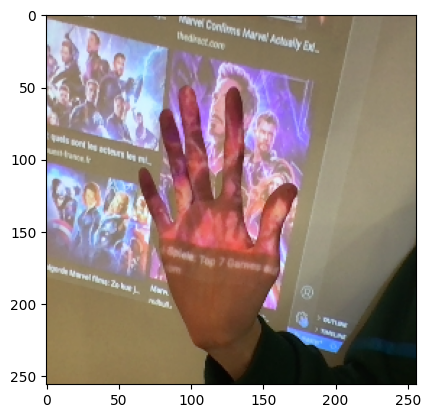

In [7]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
for i in range(10) :
    ret, np_image = cap.read()
cap.release()


input_image_np = cv2.resize(
    cv2.cvtColor(
        np_image[:, 200:-200],
        cv2.COLOR_BGR2RGB
    ),
        (256, 256),
)

input_image_tensor = torch.Tensor(
    input_image_np.transpose(2, 0, 1),
).unsqueeze(0) / 255.0

plt.imshow(input_image_np)

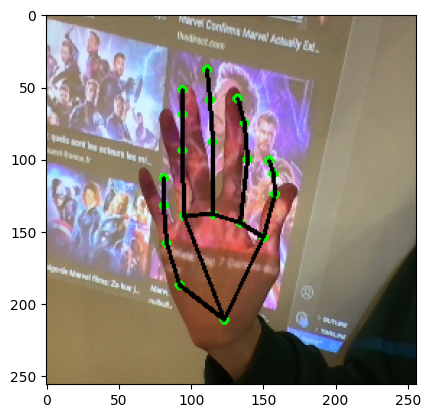

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/var/folders/rj/hhfqjm6x0zj77chzkv2pwrgr0000gn/T/ipykernel_41886/3715501608.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  landmark_mediapipe = torch.Tensor(landmark_mediapipe)


torch.Size([1, 21, 3])


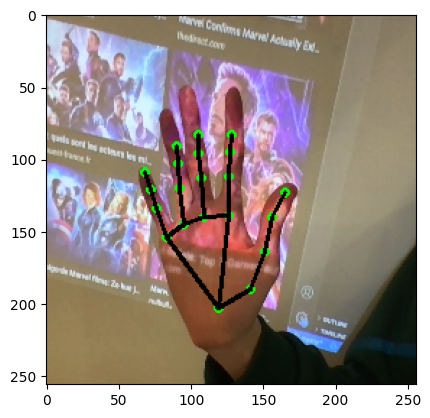

In [10]:
# blazehand
hand_flag, handed, landmarks_blaze = hand_regressor(input_image_tensor)
input_image_vis1 = input_image_np.copy()
draw_normalized_hand_landmarks_on_cropped(
    input_image_vis1,
    landmarks_blaze.detach()[0],
)
plt.imshow(input_image_vis1)
plt.show()


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


# mediapipe
with mp_hands.Hands(
    static_image_mode = False,
    model_complexity  = 1,
    min_detection_confidence = 0.2,
    min_tracking_confidence =  0.2,
) as hands:

    results = hands.process(input_image_np)
    landmark_mediapipe  = []
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:            
            landmark_mediapipe.append(
                calc_normalized_landmark_list(hand_landmarks)
            )
    else :
        print("no hand")
        
    landmark_mediapipe = torch.Tensor(landmark_mediapipe)

    print(landmark_mediapipe.shape)

    input_image_vis2 = input_image_np.copy()
    draw_normalized_hand_landmarks_on_cropped(
        input_image_vis2,
        landmark_mediapipe[0]
    )

    plt.imshow(input_image_vis2)

In [21]:
results[0].__dict__

mappingproxy({'__doc__': 'SolutionOutputs(multi_hand_landmarks, multi_hand_world_landmarks, multi_handedness)',
              '__slots__': (),
              '_fields': ('multi_hand_landmarks',
               'multi_hand_world_landmarks',
               'multi_handedness'),
              '_field_defaults': {},
              '__new__': <staticmethod(<function SolutionOutputs.__new__ at 0x13d8aeb00>)>,
              '_make': <classmethod(<function SolutionOutputs._make at 0x11228dd80>)>,
              '_replace': <function collections.SolutionOutputs._replace(self, /, **kwds)>,
              '__repr__': <function collections.SolutionOutputs.__repr__(self)>,
              '_asdict': <function collections.SolutionOutputs._asdict(self)>,
              '__getnewargs__': <function collections.SolutionOutputs.__getnewargs__(self)>,
              '__match_args__': ('multi_hand_landmarks',
               'multi_hand_world_landmarks',
               'multi_handedness'),
              'multi_hand_l

In [23]:
sss = landmark_mediapipe[0].numpy()

In [30]:
print(sss[[8, 12, 16, 20], :2])
print(sss[[8, 12, 16, 20], :2].mean(axis = 0))

[[0.50352407 0.32724124]
 [0.410959   0.3276572 ]
 [0.35219473 0.3579629 ]
 [0.2674141  0.4279794 ]]
[0.383523   0.36021018]


In [11]:
print(landmark_mediapipe.shape, landmarks_blaze.shape)
print(landmark_mediapipe.dtype, landmarks_blaze.dtype)


torch.Size([1, 21, 3]) torch.Size([1, 21, 3])
torch.float32 torch.float32


In [12]:
batch_size = 20
net_inputs = torch.stack([
    input_image_tensor[0] for i in range(batch_size)
])
net_target = torch.stack(
    [landmark_mediapipe[0] for i in range(batch_size)]
)
net_inputs.shape, net_target.shape

In [13]:
model = BlazeHandLandmark()
model.load_weights("./blazehand2.pth")

(torch.Size([20, 3, 256, 256]), torch.Size([20, 21, 3]))

In [15]:
crieterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = 0.001,
)

In [16]:
import tqdm
epochs = 10

net_inputs.requires_grad_(True)


for epoch in range(epochs) :

    optimizer.zero_grad()

    _, _, hand_landmark_pred = model(
        net_inputs
    )

    #print(hand_landmark_pred.requires_grad)

    loss = crieterion(hand_landmark_pred, net_target)
    loss.requires_grad_(True)
    print(f"epc:{epoch}, loss:{loss}")
    loss.backward()
    optimizer.step()


True
True
xyzw
True True True True
True

epc:0, loss:0.01775684580206871
True
True
xyzw
True True True True
True

epc:1, loss:0.002031185431405902
True
True
xyzw
True True True True
True

epc:2, loss:0.007478938903659582
True
True
xyzw
True True True True
True

epc:3, loss:0.0033787209540605545
True
True
xyzw
True True True True
True

epc:4, loss:0.0009936989517882466
True
True
xyzw
True True True True
True

epc:5, loss:0.0004017524770461023
True
True
xyzw
True True True True
True

epc:6, loss:0.0003421874425839633
True
True
xyzw
True True True True
True

epc:7, loss:0.0002102464932249859
True
True
xyzw
True True True True
True

epc:8, loss:0.0001718271232675761
True
True
xyzw
True True True True
True

epc:9, loss:0.00018880743300542235


False
True
xyzw
True True True True
True



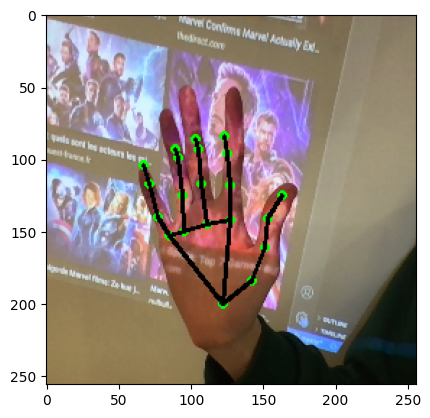

torch.Size([1, 21, 3])


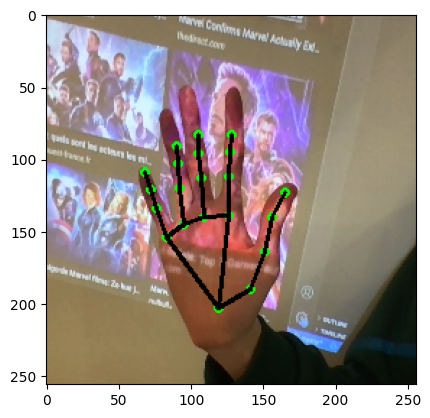

In [17]:
# blazehand
hand_flag, handed, landmarks_blaze = model(input_image_tensor)
input_image_vis1 = input_image_np.copy()
draw_normalized_hand_landmarks_on_cropped(
    input_image_vis1,
    landmarks_blaze.detach()[0],
)
plt.imshow(input_image_vis1)
plt.show()


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


# mediapipe
with mp_hands.Hands(
    static_image_mode = False,
    model_complexity  = 1,
    min_detection_confidence = 0.2,
    min_tracking_confidence =  0.2,
) as hands:

    results = hands.process(input_image_np)
    landmark_mediapipe  = []
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:            
            landmark_mediapipe.append(
                calc_normalized_landmark_list(hand_landmarks)
            )
    else :
        print("no hand")
        
    landmark_mediapipe = torch.Tensor(landmark_mediapipe)

    print(landmark_mediapipe.shape)

    input_image_vis2 = input_image_np.copy()
    draw_normalized_hand_landmarks_on_cropped(
        input_image_vis2,
        landmark_mediapipe[0]
    )

    plt.imshow(input_image_vis2)

In [19]:
torch.save(
    model.state_dict(),
    "blazehand2.pth"
)